In [1]:
# set module auto-reloaded 
%load_ext autoreload
%autoreload 2

In [2]:
# Load MNIST data set

from tensorflow.keras.datasets import mnist
train_set, test_set = mnist.load_data()

In [3]:
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, ReLU
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np
import dahuffman
import pickle
from Compressible_Huffman import Huffman
from regularization import *
from getModel import get_simplemodel

# generate a simple NN model
model = get_simplemodel()

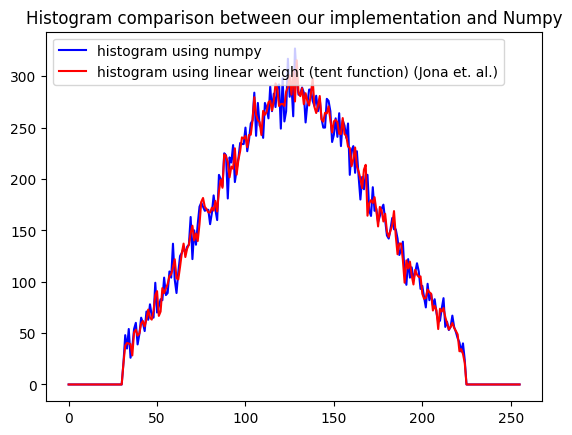

In [4]:
from regularization import visualize_histogram
variables=model.layers[3].variables[0]
visualize_histogram(variables)

In [5]:
from regularization import calculate_histogram, test_histogram, calculate_histogram_range, calculate_entropy, calc_sparsity_regularization, nbins

class CompressibleNN(keras.Model):
    def __init__(self, net_model, coeff, reg_type):
        super(CompressibleNN, self).__init__()

        # Build the model architecture
        self.net_model = net_model
        self.coeff = coeff
        self.reg_type = reg_type

    def call(self, inputs):
        return self.net_model(inputs)
    
    def entropy_loss(self, inputs, regularization_weighting_coefficient=1.0):
        entropy = 0
        
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    v_entropy, v_range = calculate_entropy(v)
                    entropy += v_entropy
        entropy = entropy * regularization_weighting_coefficient / tf.experimental.numpy.log2(tf.cast(nbins, tf.float32))
        return entropy
    
    def regularization_loss(self, inputs, regularization_weighting_coefficient=1e-2):
        rg_loss = 0
        num_activations = 0  # Initialize the total number of activations
        
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    num_activations += tf.reduce_prod(v.shape)  # Accumulate the number of activations
                    v_regularization_loss = calc_sparsity_regularization(v)
                    rg_loss += v_regularization_loss

        # Divide the total regularization loss by the total number of activations
        rg_loss = rg_loss * regularization_weighting_coefficient / tf.cast(num_activations, dtype=tf.float32)
        
        return rg_loss
    
    def train_step(self, input):
        images = input[0]
        labels = input[1]
 
        # 1. Entropy-based regularization
        if self.reg_type == 'entropy':
            with tf.GradientTape() as tape:
                output = self.net_model(images)
                loss = self.entropy_loss(images, regularization_weighting_coefficient=self.coeff)
                
            # Get the gradients w.r.t the loss
            gradient = tape.gradient(loss, self.net_model.trainable_variables)
            # Update the weights using the generator optimizer
            self.optimizer.apply_gradients(
                zip(gradient, self.net_model.trainable_variables)
            )
            
            return {"entropy_loss": loss}
        # 2. Sparsity-based regularization
        elif self.reg_type == 'sparsity':
            with tf.GradientTape() as tape:
                output = self.net_model(images)
                regularization_loss = self.regularization_loss(images, regularization_weighting_coefficient=self.coeff)

            gradient_reg = tape.gradient(regularization_loss, self.net_model.trainable_variables)
            # Update the weights using the generator optimizer
            self.optimizer.apply_gradients(
                zip(gradient_reg, self.net_model.trainable_variables)
            )
            
            return {"regularization_loss": regularization_loss}
        else:
            raise ValueError("Invalid reg_type. Use 'entropy' or 'sparsity'.")


In [6]:
# set parameters for training
coefficients = [0, 1e-3, 1e-2, 1e-3, 0.5, 1.0, 2.5, 5.0, 10.0]
regularization_type = ['entropy', 'sparsity']
results = []
num_epoch = 100
batch_size = 64

In [24]:
# Create a list of models by copying the base model
compressibleNN_list = []

for reg_type in regularization_type:
    for coeff in coefficients:
        model_instance = CompressibleNN(get_simplemodel(), coeff, reg_type)
        compressibleNN_list.append(model_instance)

In [18]:
import os

# Define the directory name
directory = "results"

# Check if the directory exists and create it if necessary
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
for compressibleNN in compressibleNN_list:
    optimizer = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)
    compressibleNN.compile(optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

    # Train the model with the current hyperparameters
    history = compressibleNN.fit(x=train_set[0], y=train_set[1], epochs=num_epoch, batch_size=batch_size)
    
    if compressibleNN.reg_type == 'entropy':
        loss = history.history['entropy_loss'][0]
    elif compressibleNN.reg_type == 'sparsity':
        loss = history.history['regularization_loss'][0]
    else:
        raise ValueError("Invalid reg_type. Use 'entropy' or 'sparsity'.")
    
    # Append the results
    results.append(f"{compressibleNN.reg_type}_loss: {loss:.3f}, coeff: {compressibleNN.coeff}, num_epoch: {num_epoch}, batch_size: {batch_size}.")

In [28]:
# Optional
# Save the original weights
for count, compressibleNN in enumerate(compressibleNN_list):
    original_weights = compressibleNN.net_model.get_weights()

    with open(f'{directory}/original_model{count}_weights.pkl', 'wb') as file:
        pickle.dump(original_weights, file)

In [29]:
# Define the full path to the log file
log_filename = os.path.join(directory, "loss_logs.txt")

# Save the results to the file
with open(log_filename, "w") as file:
    for result_entry in results:
        file.write(result_entry + "\n")

In [35]:
for count, compressibleNN in enumerate(compressibleNN_list):
    trainedNN = Huffman(compressibleNN.net_model)
    compressed_weights = trainedNN.compressNN()

    # Set compNN.weights to 0
    for layer in trainedNN.net_model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            layer.set_weights([tf.zeros_like(w) for w in layer.get_weights()])
    
    # Save the CompressibleNN instance to a file for each compressibleNN
    filename = f'{directory}/compressed_nn_{count}.pkl'  # Unique filename for each instance
    with open(filename, 'wb') as outp:
        pickle.dump(trainedNN.net_model, outp, pickle.HIGHEST_PROTOCOL)
        pickle.dump(trainedNN.codec, outp, pickle.HIGHEST_PROTOCOL)
        pickle.dump(compressed_weights, outp, pickle.HIGHEST_PROTOCOL)